In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from PIL import Image

from utils import *

import DataProcessing as dp

import tqdm
import alphashape as ap

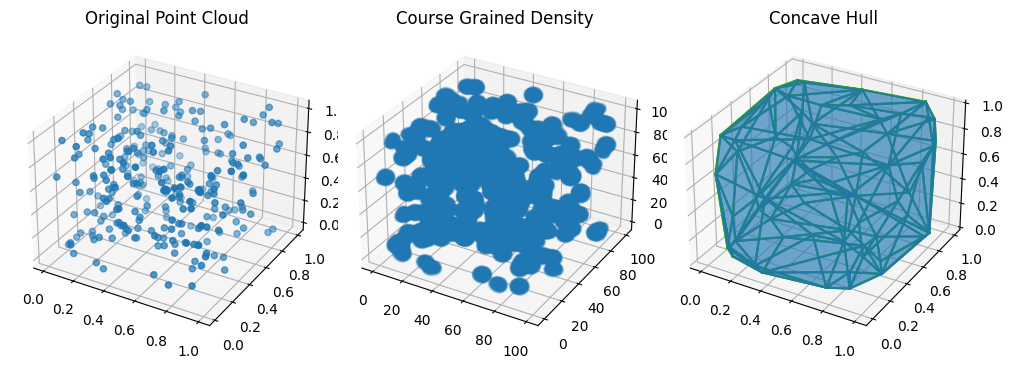

In [76]:
points = np.random.uniform(size=(300,3))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter(*points.T)
ax.set_title('Original Point Cloud')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
cgField = courseGrainField(points, kernelSize=10)
cgNormalization = np.sum(cgField)

ax2.scatter(*np.array(np.where(cgField > .001)), alpha=.1)
ax2.set_title('Course Grained Density')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
alphashape = ap.alphashape(points, alpha=.9)
for i in range(len(alphashape.faces)):
    ax3.add_collection3d(Poly3DCollection([np.array(alphashape.vertices[alphashape.faces[i]])], alpha=.4, color='tab:blue'))

for i in range(len(alphashape.edges)):
    linePoints = np.array(alphashape.vertices[alphashape.edges[i]])
    ax3.plot(*linePoints.T, c='tab:green')

ax3.set_title('Concave Hull')
fig.tight_layout()
plt.show()

In [111]:
# Completely random
#order = np.arange(len(points))
#orderedPoints = points[order]

# By nearest neighbor
order = np.zeros(len(points), dtype=np.int64) - 1
kdTree = KDTree(points)
dist, ind = kdTree.query(points, 4)
averageSpacing = np.mean([d[1:] for d in dist])

order[0] = np.random.randint(len(points))
for i in range(1, len(points)):
    dist, ind = kdTree.query(points[order[i-1]], len(points))
    order[i] = [j for j in ind if j not in order][0]
    
orderedPoints = points[order]

## Course Grained Exploration

In [114]:
images = []
fps = 20
loop = 0
plot = False
kernelSize = 100
latticeSpacing = averageSpacing / 4

coverageFractionArr = np.zeros(len(orderedPoints))

cgField = courseGrainField(points, kernelSize=kernelSize)
cgNormalization = np.sum(cgField)

for i in tqdm.tqdm(range(2, len(orderedPoints))):

    cgField = courseGrainField(orderedPoints[:i], kernelSize=kernelSize)
    coverageFractionArr[i] = np.sum(cgField) / cgNormalization
    
    if plot:
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        ax.scatter(*orderedPoints[:i].T)
        ax.set_title('Original Point Cloud')
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')

        ax2.scatter(*np.array(np.where(cgField > 1e-2)), alpha=.1)
        ax2.set_title('Course Grained Density')

        fig.suptitle(f'Index: {i}/{len(order)}, Coverage Fraction: {coverageFractionArr[i]:.4}')
        fig.tight_layout()

        canvas = plt.get_current_fig_manager().canvas
        canvas.draw()

        images.append(Image.frombytes('RGB', canvas.get_width_height(),
                     canvas.tostring_rgb()))

        plt.close()
    
if plot:
    images[0].save(f'course_grained_exploration.gif', save_all=True, append_images=images[1:], duration=fps, loop=loop)

100%|████████████████████████████████████████████████████████| 298/298 [01:25<00:00,  3.48it/s]


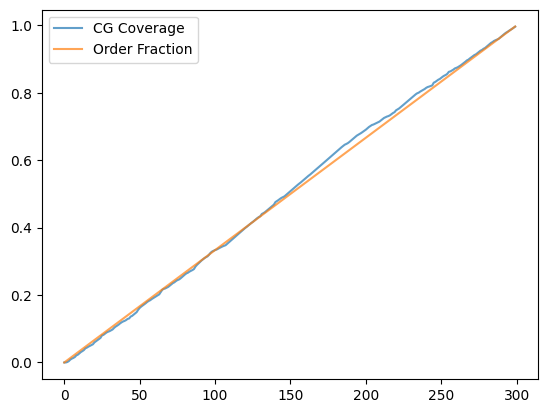

In [115]:
plt.plot(coverageFractionArr, alpha=.7, label='CG Coverage')
plt.plot(np.arange(len(coverageFractionArr))/len(coverageFractionArr), alpha=.7, label='Order Fraction')
plt.legend()
plt.show()

## Hull Exploration

In [81]:
images = []
fps = 20
loop = 0

hullVolumeArr = np.zeros(len(orderedPoints))

for i in tqdm.tqdm(range(4, len(orderedPoints))):

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    ax.scatter(*orderedPoints[:i].T)
    ax.set_title('Original Point Cloud')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    alphashape = ap.alphashape(orderedPoints[:i], alpha=.9)
    for j in range(len(alphashape.faces)):
        ax2.add_collection3d(Poly3DCollection([np.array(alphashape.vertices[alphashape.faces[j]])], alpha=.4, color='tab:blue'))

    for j in range(len(alphashape.edges)):
        linePoints = np.array(alphashape.vertices[alphashape.edges[j]])
        ax2.plot(*linePoints.T, c='tab:green')
    ax2.set_title('Concave Hull')

    fig.suptitle(f'Index: {i}/{len(order)} Hull Volume: {hullVolumeArr[i]:.4}')
    fig.tight_layout()
    
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()

    images.append(Image.frombytes('RGB', canvas.get_width_height(),
                 canvas.tostring_rgb()))

    plt.close()
    
images[0].save(f'hull_exploration.gif', save_all=True, append_images=images[1:], duration=fps, loop=loop)

100%|████████████████████████████████████████████████████████| 296/296 [03:13<00:00,  1.53it/s]
